# Create a forward Model with Freesurfer and MNE

In [15]:
import mne
import os
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D 
from mne.viz import plot_alignment, set_3d_view
from mne import setup_source_space,setup_volume_source_space, write_source_spaces
import pandas as pd
import pycartool

#Deactivate heavy plotting
plot = False
#%matplotlib inline
#%matplotlib qt
#from mpl_toolkits.mplot3d import Axes3D 
## TODO: If "fwd.fif" file already exists (forwads solution -aka leadfield matrix), then skip all steps to compute BEM

## 1) reconstruct surfaces with Freesurfer
 We need to create a folder *sub-X/* for each subject. Inside each of this folder, a subfolder *mri/* has to be created, in which we will add the T1w.nii.gz image converted to 0001.mgz (using mriconvert).<br/>
 <br/>
The *sub-X/* folder should be located in the freesurfer SUBJECTS_DIR (type echo $SUBJECTS_DIR in the terminal). <br/>
<br/>
One this is prepared, in the terminal run the following FREESURFER function: <br/>
> recon-all -subject sub-X -all 

## 2) Compute BEM surfaces 
We need to compute the different BEM surfaces using MNE, which are needed for the forward computation, using the FREESURFER output surfaces. 
> mne watershed_bem -s sub-X

In [5]:
# Path to data
USR = os.getenv('USER')
if USR == "localadmin":
    datafold = "/home/localadmin/Desktop/Joan/Cluster/data/SINERGIA_2019"
elif USR == "jo8558":
    datafold = "/home/jo8558/data/SINERGIA_2019"

sub = 1

subject = str(sub).zfill(2)
subjects_dir = os.path.join(datafold,'03_ANATOMY','freesurfer','subjects')

if "bem" not in os.listdir(os.path.join(subjects_dir,"sub-"+subject)):
    cmd = "export SUBJECTS_DIR="+subjects_dir
    os.system(cmd)
    cmd = "mne watershed_bem -s sub-"+subject
    os.system(cmd)

if plot:
    mne.viz.plot_bem(subject="sub-"+subject, subjects_dir=subjects_dir,
                     brain_surfaces='white', orientation='coronal');

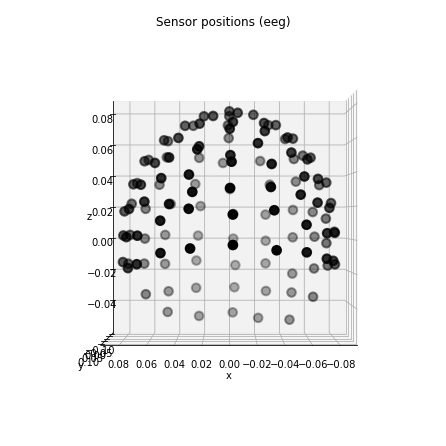

In [26]:
# Load EEG electrode locations and transformation matrix to the original space

fif_fname = os.path.join(datafold,'MNE_tmp','sub-'+subject,'sub-'+subject+'-montage.fif')
if False:#os.path.exists(fif_fname):
    montage = mne.channels.read_dig_fif(fif_fname)
else:
    montage_fname = os.path.join(datafold,'02_ESI_CARTOOL','CartoolFiles','sub-'+subject,'sub-'+subject+'.xyz')
    dev_head_t_fname = os.path.join(datafold,'02_ESI_CARTOOL','CartoolFiles','sub-'+subject,'More','sub-'+subject+'.Transform.Electrodes Coregistration.Electrodes to Original MRI.txt')
    dev_head_t = np.loadtxt(dev_head_t_fname)

    n = int(open(montage_fname).readline().lstrip().split(' ')[0])
    all_coord = np.loadtxt(montage_fname, skiprows=1, usecols=(0, 1, 2), max_rows=n)
    all_names = np.loadtxt(montage_fname, skiprows=1, usecols=3, max_rows=n,dtype=np.dtype(str)).tolist()
    all_coord = list(map(lambda x: x/1000,all_coord))
    #all_coord = list(map(lambda x: np.dot(dev_head_t[:3,:],np.concatenate((x,[1])))/1000,all_coord))
    
    nas_coord = all_coord[all_names.index('nasion')]
    lpa_coord = all_coord[all_names.index('lpa')]
    rpa_coord = all_coord[all_names.index('rpa')]
    ch_coord  = [all_coord[idx] for idx, chan in  enumerate(all_names) if chan not in ['lpa','rpa','nasion']]
    ch_names  = [all_names[idx] for idx, chan in  enumerate(all_names) if chan not in ['lpa','rpa','nasion']]
    


    montage = mne.channels.make_dig_montage(ch_pos=dict(zip(ch_names, ch_coord)),nasion=nas_coord,rpa=rpa_coord,lpa=lpa_coord,coord_frame='head')
    
    montage.dev_head_t = dev_head_t
    montage.save(fif_fname)

montage.plot();

We need to compute go back to the terminal to comptue the *trans.fif* file:
> mne coreg 

Here we should pick the subject that we are processing, and select the digitization file that we just created (*subX-montage.fif*). Once we uploaded these files, we can just press "fit" to transform the electrodes position to fit the head's shape. <\br>
Finally, we need to save the resulting transformation in a file named *sub-X-trans.fif*

In [27]:
trans_fname = os.path.join(datafold,'MNE_tmp','sub-'+subject,'sub-'+subject+'-trans.fif')
info = mne.create_info(ch_names, 250., 'eeg', montage=montage)
if plot:
    fig_scatter = plot_alignment(info,trans=trans_fname, subject='sub-'+subject,subjects_dir=subjects_dir,
                                 dig=False,
                                 eeg=['original'],
                                 surfaces='pial')
    set_3d_view(fig_scatter, 200, 70)

(check external window)

In [28]:
info

<Info | 17 non-empty fields
    bads : list | 0 items
    ch_names : list | A1, A2, A3, A4, A5, A6, A7, A8, A9, ...
    chs : list | 128 items (EEG: 128)
    comps : list | 0 items
    custom_ref_applied : bool | False
    dev_head_t : Transform | 3 items
    dig : Digitization | 131 items (3 Cardinal, 128 EEG)
    events : list | 0 items
    highpass : float | 0.0 Hz
    hpi_meas : list | 0 items
    hpi_results : list | 0 items
    lowpass : float | 125.0 Hz
    meas_date : NoneType | unspecified
    nchan : int | 128
    proc_history : list | 0 items
    projs : list | 0 items
    sfreq : float | 250.0 Hz
    acq_pars : NoneType
    acq_stim : NoneType
    ctf_head_t : NoneType
    description : NoneType
    dev_ctf_t : NoneType
    device_info : NoneType
    experimenter : NoneType
    file_id : NoneType
    gantry_angle : NoneType
    helium_info : NoneType
    hpi_subsystem : NoneType
    kit_system_id : NoneType
    line_freq : NoneType
    meas_id : NoneType
    proj_id : NoneT

## 4) Setup source space
There are two types of source space: surface-based or volumetric. 

First create the BEM model

In [16]:
conductivity = (0.3, 0.006, 0.3)  # for three layers
for elem in ["inner_skull","outer_skull","outer_skin"]:
    if (elem not in os.listdir(os.path.join(subjects_dir,'sub-'+subject,'bem'))) and ("watershed" in os.listdir(os.path.join(subjects_dir,'sub-'+subject,'bem'))):
        cmd = 'cp '+ os.path.join(subjects_dir,'sub-'+subject,'bem','watershed','*'+elem+'*') + ' ' + os.path.join(subjects_dir,'sub-'+subject,'bem',elem+'.surf')
        os.system(cmd)    
                                                                                          
                                                                                          
model = mne.make_bem_model(subject='sub-'+subject, ico=4,
                           conductivity=conductivity,
                           subjects_dir=subjects_dir)
bem = mne.make_bem_solution(model)

Creating the BEM geometry...
Going from 5th to 4th subdivision of an icosahedron (n_tri: 20480 -> 5120)
Going from 5th to 4th subdivision of an icosahedron (n_tri: 20480 -> 5120)
Going from 5th to 4th subdivision of an icosahedron (n_tri: 20480 -> 5120)
outer skin  CM is  -0.91  -9.64  10.52 mm
outer skull CM is  -0.91  -9.53  10.07 mm
inner skull CM is  -0.86 -11.41  18.22 mm
Checking that outer skull surface is inside outer skin  surface...
Checking that inner skull surface is inside outer skull surface...
Checking distance between outer skin  and outer skull surfaces...
Minimum distance between the outer skin  and outer skull surfaces is approximately    0.0 mm
Checking distance between outer skull and inner skull surfaces...
Minimum distance between the outer skull and inner skull surfaces is approximately 1000.0 mm
Surfaces passed the basic topology checks.
Complete.

Approximation method : Linear collocation

Three-layer model surfaces loaded.
Computing the linear collocation sol

In [22]:
src_fname = os.path.join(datafold,'MNE_tmp','sub-'+subject,'sub-'+subject+'-oct6-src.fif')
fname_aseg = os.path.join(subjects_dir,'sub-'+subject, 'mri', 'aparc+aseg.mgz')

if not os.path.exists(src_fname):
    src = setup_source_space(subject = 'sub-'+subject, spacing='oct6', subjects_dir=subjects_dir)  
    vol_src = setup_volume_source_space(subject= 'sub-'+subject, mri=fname_aseg, pos=5.0, bem=bem,
                                        add_interpolator=True, subjects_dir=subjects_dir)
    src += vol_src
    write_source_spaces(src_fname,src)
else:
    src = mne.read_source_spaces(src_fname, patch_stats=False, verbose=None)

    Reading a source space...
    Computing patch statistics...
    Patch information added...
    Distance information added...
    [done]
    Reading a source space...
    Computing patch statistics...
    Patch information added...
    Distance information added...
    [done]
    2 source spaces read
BEM              : <ConductorModel  |  BEM (3 layers)>
grid                  : 5.0 mm
mindist               : 5.0 mm
MRI volume            : /home/jo8558/data/SINERGIA_2019/03_ANATOMY/freesurfer/subjects/sub-01/mri/aparc+aseg.mgz

Taking inner skull from <ConductorModel  |  BEM (3 layers)>
Surface CM = (  -0.9  -11.4   18.2) mm
Surface fits inside a sphere with radius  102.3 mm
Surface extent:
    x =  -72.2 ...   73.0 mm
    y = -105.6 ...   89.9 mm
    z =  -58.1 ...   85.4 mm
Grid extent:
    x =  -75.0 ...   75.0 mm
    y = -110.0 ...   90.0 mm
    z =  -60.0 ...   90.0 mm
39401 sources before omitting any.
30052 sources after omitting infeasible sources not within 0.0 - 102.3 mm.
S

In [23]:
if plot:
    mne.viz.plot_bem(subject='sub-'+subject, subjects_dir=subjects_dir,
                     brain_surfaces='white', src=src, orientation='coronal')

In [24]:
if plot:
    fig = mne.viz.plot_alignment(subject='sub-'+subject, subjects_dir=subjects_dir,
                                 surfaces='white', coord_frame='head',
                                 src=src)
    mne.viz.set_3d_view(fig, azimuth=173.78, elevation=101.75,
                        distance=0.30, focalpoint=(-0.03, -0.01, 0.03))

## 5) Compute forward solution

Compute leadfield matrix

In [29]:
fwd_fname = os.path.join(datafold,'MNE_tmp','sub-'+subject,'fwd.fif')
if not(os.path.exists(fwd_fname)):
    fwd = mne.make_forward_solution(info, trans=trans_fname, src=src,
                                    bem=bem, eeg=True, mindist=5.0, n_jobs=4)

    mne.write_forward_solution(fwd_fname, fwd, overwrite=True, verbose=None)
else:
    fwd = mne.read_forward_solution(fwd_fname)
print(fwd)

Source space          : <SourceSpaces: [<surface (lh), n_vertices=148447, n_used=4098, coordinate_frame=MRI (surface RAS)>, <surface (rh), n_vertices=147188, n_used=4098, coordinate_frame=MRI (surface RAS)>, <volume, shape=[31 41 31], n_used=13228, coordinate_frame=MRI (surface RAS)>]>
MRI -> head transform : /home/jo8558/data/SINERGIA_2019/MNE_tmp/sub-01/sub-01-trans.fif
Measurement data      : instance of Info
Conductor model   : instance of ConductorModel
Accurate field computations
Do computations in head coordinates
Free source orientations

Read 3 source spaces a total of 21424 active source locations

Coordinate transformation: MRI (surface RAS) -> head
     0.999982 -0.002837 -0.005212      -0.38 mm
     0.003133  0.998321  0.057846       9.89 mm
     0.005039 -0.057861  0.998312     -26.73 mm
     0.000000  0.000000  0.000000       1.00

Read 128 EEG channels from info
Head coordinate coil definitions created.
Source spaces are now in head coordinates.

Employing the head->MRI

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


    Skipping interior check for 1518 sources that fit inside a sphere of radius   52.2 mm


[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    1.7s remaining:    1.7s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    1.8s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    1.8s finished


    Skipping solid angle check for 0 points using Qhull


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


    1 source space point omitted because of the    5.0-mm distance limit.
    Computing patch statistics...
    Patch information added...
    Skipping interior check for 4754 sources that fit inside a sphere of radius   52.2 mm
    Skipping solid angle check for 0 points using Qhull


[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    1.0s remaining:    1.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    1.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    1.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    2.9s remaining:    2.9s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    3.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    3.0s finished


Computing EEG at 21423 source locations (free orientations)...


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    5.8s remaining:    5.8s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    6.2s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    6.2s finished



Finished.
Overwriting existing file.


<ipython-input-29-e17cc6b65f02>:6: RuntimeWarning: This filename (/home/jo8558/data/SINERGIA_2019/MNE_tmp/sub-01/fwd.fif) does not conform to MNE naming conventions. All forward files should end with -fwd.fif, -fwd.fif.gz, _fwd.fif or _fwd.fif.gz
  mne.write_forward_solution(fwd_fname, fwd, overwrite=True, verbose=None)


    Write a source space...
    [done]
    Write a source space...
    [done]
    Write a source space...
    [done]
    3 source spaces written
<Forward | MEG channels: 0 | EEG channels: 128 | Source space: Mixed (2 surface, 1 volume) with 21423 vertices | Source orientation: Free>


To extract the numpy array containing the forward operator corresponding to the source space fwd[‘src’] with cortical orientation constraint we can use the following:

This is equivalent to the following code that explicitly applies the forward operator to a source estimate composed of the identity operator:

In [30]:
eeg_map = mne.sensitivity_map(fwd, ch_type='eeg', mode='free')
if plot:
    eeg_map.plot(time_label='EEG sensitivity', subjects_dir=subjects_dir,
                 clim=dict(lims=[0, 50, 100]))

    128 out of 128 channels remain after picking
Adding average EEG reference projection.


ValueError: Number of vertices (8195) and stc.shape[0] (21423) must match

In [31]:
# Path to EEGlab files
EEG_path = os.path.join(datafold,'01_EEG_PREP','Data_FaceTask',subject,subject+'_FACES_250HZ_prepd.set') 

epochs = mne.read_epochs_eeglab(EEG_path, events=None, event_id=None, eog=(), verbose=None, uint16_codec=None)
epochs.set_montage(montage,raise_if_subset=False)
epochs.apply_baseline((0,None))
epochs.set_eeg_reference('average',projection = True)
epochs.apply_proj()

Extracting parameters from /home/jo8558/data/SINERGIA_2019/01_EEG_PREP/Data_FaceTask/01/01_FACES_250HZ_prepd.set...


<ipython-input-31-2a0e21577bbe>:4: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epochs = mne.read_epochs_eeglab(EEG_path, events=None, event_id=None, eog=(), verbose=None, uint16_codec=None)


588 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
Ready.
Applying baseline correction (mode: mean)
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
Created an SSP operator (subspace dimension = 1)
1 projection items activated
SSP projectors applied...


<EpochsEEGLAB  |   588 events (all good), -1.5 - 0.996 sec, baseline [0, None], ~359.2 MB, data loaded,
 '65344/FACES/65344/correct/65344/CONTROL/65344/correct/65344': 1
 '65344/correct/65344/CONTROL/65344/correct': 9
 '65344/correct/65344/CONTROL/65344/correct/65344': 27
 '65344/correct/65344/FACES/65344/correct': 7
 '65344/correct/65344/FACES/65344/correct/65344': 24
 'CONTROL/65344/correct/65344': 1
 'CONTROL/65344/correct/65344/CONTROL/65344/correct': 20
 'CONTROL/65344/correct/65344/CONTROL/65344/correct/65344': 102
 'CONTROL/65344/correct/65344/CONTROL/65344/error/65344': 1
 'CONTROL/65344/correct/65344/FACES/65344': 1
 'CONTROL/65344/correct/65344/FACES/65344/correct': 15
 'CONTROL/65344/correct/65344/FACES/65344/correct/65344': 112
 'CONTROL/65344/error/65344/FACES/65344/correct/65344': 1
 'FACES/65344/correct/65344': 3
 'FACES/65344/correct/65344/CONTROL/65344/correct': 12
 'FACES/65344/correct/65344/CONTROL/65344/correct/65344': 116
 'FACES/65344/correct/65344/FACES/65344/cor

In [32]:
epochs.info['dev_head_t']

<Transform  |  MEG device->head>
[[  1.0067926   0.          0.         90.       ]
 [  0.          0.999814    0.1183358 108.6827245]
 [  0.         -0.1183358   0.999814  117.6446927]
 [  0.          0.          0.          1.       ]]

In [33]:
cov_fname = os.path.join(datafold,"MNE_tmp",'sub-'+subject,"noise_cov.fif")
if os.path.exists(cov_fname):
    noise_cov = mne.read_cov(cov_fname)
else:
    noise_cov = mne.compute_covariance(
    epochs, tmax=0., method=['shrunk', 'empirical'], rank=None, verbose=True)
    mne.write_cov(cov_fname,noise_cov)

    128 x 128 full covariance (kind = 1) found.
    Read a total of 1 projection items:
        Average EEG reference (1 x 128) active


In [34]:
noise_cov

<Covariance  |  size : 128 x 128, n_samples : 2650800, data : [[ 5.38782896e-13  4.38435043e-13  3.19553368e-13 ... -4.34747966e-13
  -4.34942601e-13 -5.21656930e-13]
 [ 4.38435043e-13  5.40549850e-13  4.10254329e-13 ... -2.72878865e-13
  -2.73147803e-13 -3.74455047e-13]
 [ 3.19553368e-13  4.10254329e-13  8.88045441e-13 ... -8.39066517e-14
  -8.44245765e-14 -1.92586671e-13]
 ...
 [-4.34747966e-13 -2.72878865e-13 -8.39066517e-14 ...  1.07727746e-12
   1.07061101e-12  1.06381818e-12]
 [-4.34942601e-13 -2.73147803e-13 -8.44245765e-14 ...  1.07061101e-12
   1.07678013e-12  1.06435474e-12]
 [-5.21656930e-13 -3.74455047e-13 -1.92586671e-13 ...  1.06381818e-12
   1.06435474e-12  1.46385128e-12]]>

In [35]:
if plot:
    fig_cov, fig_spectra = mne.viz.plot_cov(noise_cov, info)

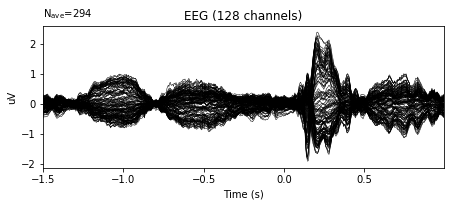

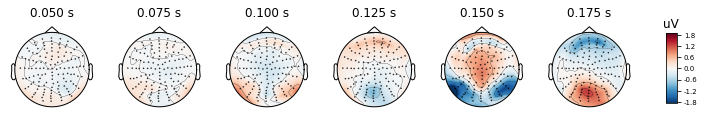

Computing data rank from covariance with rank=None
    Using tolerance 2.1e-14 (2.2e-16 eps * 128 dim * 0.73  max singular value)
    Estimated rank (eeg): 127
    EEG: rank 127 computed from 128 data channels with 1 projector
    Created an SSP operator (subspace dimension = 1)
Computing data rank from covariance with rank={'eeg': 127}
    Setting small EEG eigenvalues to zero (without PCA)
    Created the whitener using a noise covariance matrix with rank 127 (1 small eigenvalues omitted)


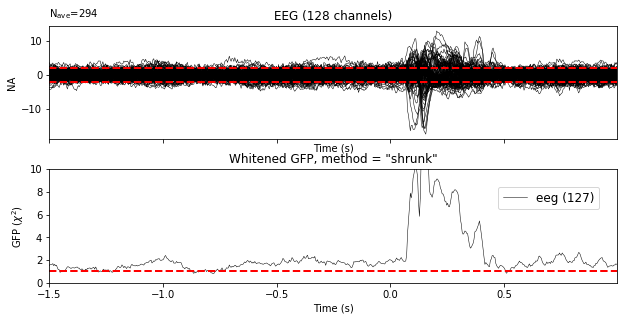

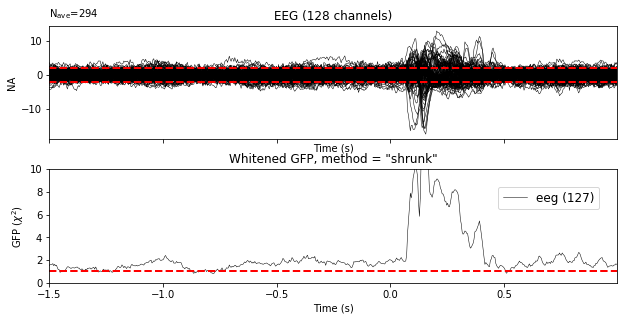

In [36]:
Behav_path = os.path.join(datafold,'01_EEG_PREP','Data_FaceTask',subject,subject+'_FACES_250HZ_behav.txt')
Behavfile = pd.read_csv(Behav_path, sep=",")
Behavfile = Behavfile[Behavfile.bad_trials == 0]
epochs.events[:,2] = Behavfile.COND
epochs.event_id = {"Scrambled":0, "Faces":1}
evoked_scra = epochs['Scrambled'].average()
evoked_faces = epochs['Faces'].average()
evoked_faces.plot(time_unit='s')
evoked_faces.plot_topomap(times=np.linspace(0.05, 0.175, 6), ch_type='eeg',
                    time_unit='s')
# Show whitening
evoked_faces.plot_white(noise_cov, time_unit='s')

In [37]:
fwd

<Forward | MEG channels: 0 | EEG channels: 128 | Source space: Mixed (2 surface, 1 volume) with 21423 vertices | Source orientation: Free>

In [38]:
inverse_operator = mne.minimum_norm.make_inverse_operator(epochs.info, fwd, noise_cov)

Computing inverse operator with 128 channels.
    128 out of 128 channels remain after picking
Selected 128 channels
Creating the depth weighting matrix...
    128 EEG channels
    limit = 21424/21423 = 6.255465
    scale = 162456 exp = 0.8
Whitening the forward solution.
    Created an SSP operator (subspace dimension = 1)
Computing data rank from covariance with rank=None
    Using tolerance 2.1e-14 (2.2e-16 eps * 128 dim * 0.73  max singular value)
    Estimated rank (eeg): 127
    EEG: rank 127 computed from 128 data channels with 1 projector
    Setting small EEG eigenvalues to zero (without PCA)
Creating the source covariance matrix
Adjusting source covariance matrix.
Computing SVD of whitened and weighted lead field matrix.
    largest singular value = 11.2055
    scaling factor to adjust the trace = 1.14635e+26


In [39]:
inverse_operator

<InverseOperator | MEG channels: 0 | EEG channels: 128 | Source space: mixed with 21423 sources | Source orientation: Free>

Compute inverse solution

In [40]:
surfer_kwargs = dict(
    hemi='rh', subjects_dir=subjects_dir,
    clim=dict(kind='value',), views='lateral',
    initial_time=0.16, time_unit='s')

In [41]:
method = "eLORETA"
snr = 3.
lambda2 = 1. / snr ** 2
evoked = epochs.average()

print('Computing SOURCE data faces')

stcs = mne.minimum_norm.apply_inverse_epochs(epochs, inverse_operator, lambda2, method, 
                            pick_ori=None, nave=evoked.nave)



Computing SOURCE data faces
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 588
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 127 (1 small eigenvalues omitted)
    Computing noise-normalization factors (eLORETA)...
        Using independent orientation weights
        Fitting up to 20 iterations (this make take a while)...
        Converged on iteration 9 (9.6e-07 < 1e-06)
        Assembling eLORETA kernel and modifying inverse
[done]
Picked 128 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 588
combining the current components...
Processing epoch : 2 / 588
combining the current components...
Processing epoch : 3 / 588
combining the current components...
Processing epoch : 4 / 588
combining the current components...
Processing epoch : 5 / 588
combining the curren

Processing epoch : 118 / 588
combining the current components...
Processing epoch : 119 / 588
combining the current components...
Processing epoch : 120 / 588
combining the current components...
Processing epoch : 121 / 588
combining the current components...
Processing epoch : 122 / 588
combining the current components...
Processing epoch : 123 / 588
combining the current components...
Processing epoch : 124 / 588
combining the current components...
Processing epoch : 125 / 588
combining the current components...
Processing epoch : 126 / 588
combining the current components...
Processing epoch : 127 / 588
combining the current components...
Processing epoch : 128 / 588
combining the current components...
Processing epoch : 129 / 588
combining the current components...
Processing epoch : 130 / 588
combining the current components...
Processing epoch : 131 / 588
combining the current components...
Processing epoch : 132 / 588
combining the current components...
Processing epoch : 133 / 

combining the current components...
Processing epoch : 245 / 588
combining the current components...
Processing epoch : 246 / 588
combining the current components...
Processing epoch : 247 / 588
combining the current components...
Processing epoch : 248 / 588
combining the current components...
Processing epoch : 249 / 588
combining the current components...
Processing epoch : 250 / 588
combining the current components...
Processing epoch : 251 / 588
combining the current components...
Processing epoch : 252 / 588
combining the current components...
Processing epoch : 253 / 588
combining the current components...
Processing epoch : 254 / 588
combining the current components...
Processing epoch : 255 / 588
combining the current components...
Processing epoch : 256 / 588
combining the current components...
Processing epoch : 257 / 588
combining the current components...
Processing epoch : 258 / 588
combining the current components...
Processing epoch : 259 / 588
combining the current com

Processing epoch : 371 / 588
combining the current components...
Processing epoch : 372 / 588
combining the current components...
Processing epoch : 373 / 588
combining the current components...
Processing epoch : 374 / 588
combining the current components...
Processing epoch : 375 / 588
combining the current components...
Processing epoch : 376 / 588
combining the current components...
Processing epoch : 377 / 588
combining the current components...
Processing epoch : 378 / 588
combining the current components...
Processing epoch : 379 / 588
combining the current components...
Processing epoch : 380 / 588
combining the current components...
Processing epoch : 381 / 588
combining the current components...
Processing epoch : 382 / 588
combining the current components...
Processing epoch : 383 / 588
combining the current components...
Processing epoch : 384 / 588
combining the current components...
Processing epoch : 385 / 588
combining the current components...
Processing epoch : 386 / 

combining the current components...
Processing epoch : 498 / 588
combining the current components...
Processing epoch : 499 / 588
combining the current components...
Processing epoch : 500 / 588
combining the current components...
Processing epoch : 501 / 588
combining the current components...
Processing epoch : 502 / 588
combining the current components...
Processing epoch : 503 / 588
combining the current components...
Processing epoch : 504 / 588
combining the current components...
Processing epoch : 505 / 588
combining the current components...
Processing epoch : 506 / 588
combining the current components...
Processing epoch : 507 / 588
combining the current components...
Processing epoch : 508 / 588
combining the current components...
Processing epoch : 509 / 588
combining the current components...
Processing epoch : 510 / 588
combining the current components...
Processing epoch : 511 / 588
combining the current components...
Processing epoch : 512 / 588
combining the current com

In [42]:
labels = mne.read_labels_from_annot(
    'sub-'+subject, subjects_dir=subjects_dir)

Reading labels from parcellation...
   read 34 labels from /home/jo8558/data/SINERGIA_2019/03_ANATOMY/freesurfer/subjects/sub-01/label/lh.aparc.annot
   read 34 labels from /home/jo8558/data/SINERGIA_2019/03_ANATOMY/freesurfer/subjects/sub-01/label/rh.aparc.annot


In [49]:
labels_ts = mne.extract_label_time_course(stcs, labels, src, mode='max', allow_empty=False, return_generator=False, verbose=None)

Extracting time courses for 69 labels (mode: max)
Extracting time courses for 69 labels (mode: max)
Extracting time courses for 69 labels (mode: max)
Extracting time courses for 69 labels (mode: max)
Extracting time courses for 69 labels (mode: max)
Extracting time courses for 69 labels (mode: max)
Extracting time courses for 69 labels (mode: max)
Extracting time courses for 69 labels (mode: max)
Extracting time courses for 69 labels (mode: max)
Extracting time courses for 69 labels (mode: max)
Extracting time courses for 69 labels (mode: max)
Extracting time courses for 69 labels (mode: max)
Extracting time courses for 69 labels (mode: max)
Extracting time courses for 69 labels (mode: max)
Extracting time courses for 69 labels (mode: max)
Extracting time courses for 69 labels (mode: max)
Extracting time courses for 69 labels (mode: max)
Extracting time courses for 69 labels (mode: max)
Extracting time courses for 69 labels (mode: max)
Extracting time courses for 69 labels (mode: max)


Extracting time courses for 69 labels (mode: max)
Extracting time courses for 69 labels (mode: max)
Extracting time courses for 69 labels (mode: max)
Extracting time courses for 69 labels (mode: max)
Extracting time courses for 69 labels (mode: max)
Extracting time courses for 69 labels (mode: max)
Extracting time courses for 69 labels (mode: max)
Extracting time courses for 69 labels (mode: max)
Extracting time courses for 69 labels (mode: max)
Extracting time courses for 69 labels (mode: max)
Extracting time courses for 69 labels (mode: max)
Extracting time courses for 69 labels (mode: max)
Extracting time courses for 69 labels (mode: max)
Extracting time courses for 69 labels (mode: max)
Extracting time courses for 69 labels (mode: max)
Extracting time courses for 69 labels (mode: max)
Extracting time courses for 69 labels (mode: max)
Extracting time courses for 69 labels (mode: max)
Extracting time courses for 69 labels (mode: max)
Extracting time courses for 69 labels (mode: max)


Extracting time courses for 69 labels (mode: max)
Extracting time courses for 69 labels (mode: max)
Extracting time courses for 69 labels (mode: max)
Extracting time courses for 69 labels (mode: max)
Extracting time courses for 69 labels (mode: max)
Extracting time courses for 69 labels (mode: max)
Extracting time courses for 69 labels (mode: max)
Extracting time courses for 69 labels (mode: max)
Extracting time courses for 69 labels (mode: max)
Extracting time courses for 69 labels (mode: max)
Extracting time courses for 69 labels (mode: max)
Extracting time courses for 69 labels (mode: max)
Extracting time courses for 69 labels (mode: max)
Extracting time courses for 69 labels (mode: max)
Extracting time courses for 69 labels (mode: max)
Extracting time courses for 69 labels (mode: max)
Extracting time courses for 69 labels (mode: max)
Extracting time courses for 69 labels (mode: max)
Extracting time courses for 69 labels (mode: max)
Extracting time courses for 69 labels (mode: max)


Extracting time courses for 69 labels (mode: max)
Extracting time courses for 69 labels (mode: max)
Extracting time courses for 69 labels (mode: max)
Extracting time courses for 69 labels (mode: max)
Extracting time courses for 69 labels (mode: max)
Extracting time courses for 69 labels (mode: max)
Extracting time courses for 69 labels (mode: max)
Extracting time courses for 69 labels (mode: max)
Extracting time courses for 69 labels (mode: max)
Extracting time courses for 69 labels (mode: max)
Extracting time courses for 69 labels (mode: max)
Extracting time courses for 69 labels (mode: max)
Extracting time courses for 69 labels (mode: max)
Extracting time courses for 69 labels (mode: max)
Extracting time courses for 69 labels (mode: max)
Extracting time courses for 69 labels (mode: max)
Extracting time courses for 69 labels (mode: max)
Extracting time courses for 69 labels (mode: max)
Extracting time courses for 69 labels (mode: max)
Extracting time courses for 69 labels (mode: max)


In [50]:
#STC_erp_cond0 = np.zeros((8195,625, np.sum(Behavfile.COND==0)))
#STC_erp_cond1 = np.zeros((8195,625, np.sum(Behavfile.COND==1)))


EEG_erp_cond0 = np.zeros((128,625, np.sum(Behavfile.COND==0)))
EEG_erp_cond1 = np.zeros((128,625, np.sum(Behavfile.COND==1)))

ESI_erp_cond0 = np.zeros((69,625, np.sum(Behavfile.COND==0)))
ESI_erp_cond1 = np.zeros((69,625, np.sum(Behavfile.COND==1)))

count0 = 0
count1 = 0
epok_data = epochs.get_data()
for i in range(333,len(Behavfile.COND)):
    print(i)
    if epochs.events[i,2]==0:
        EEG_erp_cond0[:,:,count0] = epok_data[i]
    #    STC_erp_cond0[:,:,count0] = stcs[i].data
        ESI_erp_cond0[:,:,count0] = labels_ts[i]
        count0 += 1
    elif epochs.events[i,2]==1:
        EEG_erp_cond1[:,:,count1] = epok_data[i]
    #    STC_erp_cond1[:,:,count1] = stcs[i].data
        ESI_erp_cond1[:,:,count1] = labels_ts[i]
        count1 += 1 

333
334
335
336
337
338
339
340
341
342
343
344
345
346
347
348
349
350
351
352
353
354
355
356
357
358
359
360
361
362
363
364
365
366
367
368
369
370
371
372
373
374
375
376
377
378
379
380
381
382
383
384
385
386
387
388
389
390
391
392
393
394
395
396
397
398
399
400
401
402
403
404
405
406
407
408
409
410
411
412
413
414
415
416
417
418
419
420
421
422
423
424
425
426
427
428
429
430
431
432
433
434
435
436
437
438
439
440
441
442
443
444
445
446
447
448
449
450
451
452
453
454
455
456
457
458
459
460
461
462
463
464
465
466
467
468
469
470
471
472
473
474
475
476
477
478
479
480
481
482
483
484
485
486
487
488
489
490
491
492
493
494
495
496
497
498
499
500
501
502
503
504
505
506
507
508
509
510
511
512
513
514
515
516
517
518
519
520
521
522
523
524
525
526
527
528
529
530
531
532
533
534
535
536
537
538
539
540
541
542
543
544
545
546
547
548
549
550
551
552
553
554
555
556
557
558
559
560
561
562
563
564
565
566
567
568
569
570
571
572
573
574
575
576
577
578
579
580
581
582


In [51]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
crossval = 10
nsamples = 625
accuracy_eeg = np.zeros((nsamples,crossval))
#accuracy_stc = np.zeros((nsamples,crossval))
accuracy_esi = np.zeros((nsamples,crossval))
X1_eeg = EEG_erp_cond0
X2_eeg = EEG_erp_cond1
#X1_stc = STC_erp_cond0
#X2_stc = STC_erp_cond1
X1_esi = ESI_erp_cond0
X2_esi = ESI_erp_cond1

n1 = len(X1_eeg)
n2 = len(X2_eeg)
clf = LDA()

for t in range(nsamples):
    for cv in range(crossval):
        ids_1 = np.random.permutation(n1)
        ids_2 = np.random.permutation(n2)
        clf.fit(np.concatenate((X1_eeg[:,t,ids_1[:int(n1*0.75)]].T,X2_eeg[:,t,ids_2[:int(n2*0.75)]].T)), np.concatenate((np.zeros(int(n1*0.75)),np.ones(int(n2*0.75)))))                        
        accuracy_eeg[t,cv] = np.mean(clf.predict(np.concatenate((X1_eeg[:,t,ids_1[-int(n1*0.25):]].T,X2_eeg[:,t,ids_2[-int(n2*0.25):]].T))) == np.concatenate((np.zeros(int(n1*0.25)),np.ones(int(n2*0.25)))))
        #clf.fit(np.concatenate((X1_stc[:,t,ids_1[:int(n1*0.75)]].T,X2_stc[:,t,ids_2[:int(n2*0.75)]].T)), np.concatenate((np.zeros(int(n1*0.75)),np.ones(int(n2*0.75)))))                        
        #accuracy_eeg[t,cv] = np.mean(clf.predict(np.concatenate((X1_stc[:,t,ids_1[-int(n1*0.25):]].T,X2_stc[:,t,ids_2[-int(n2*0.25):]].T))) == np.concatenate((np.zeros(int(n1*0.25)),np.ones(int(n2*0.25)))))
        clf.fit(np.concatenate((X1_esi[:,t,ids_1[:int(n1*0.75)]].T,X2_esi[:,t,ids_2[:int(n2*0.75)]].T)), np.concatenate((np.zeros(int(n1*0.75)),np.ones(int(n2*0.75)))))                        
        accuracy_esi[t,cv] = np.mean(clf.predict(np.concatenate((X1_esi[:,t,ids_1[-int(n1*0.25):]].T,X2_esi[:,t,ids_2[-int(n2*0.25):]].T))) == np.concatenate((np.zeros(int(n1*0.25)),np.ones(int(n2*0.25)))))
       

/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/skle

/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/skle

/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/skle

/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/skle

/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/skle

/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/skle

/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/skle

/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/skle

/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/skle

/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/skle

/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/skle

/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/skle

/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/skle

/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/skle

/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/skle

/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/skle

/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/skle

/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/skle

/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/skle

/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/skle

/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/skle

/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/skle

/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/skle

/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/skle

/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/skle

/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/skle

/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/skle

/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/skle

/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/skle

/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/skle

/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/skle

/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/skle

/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/skle

/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/skle

/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/skle

/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/skle

/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/skle

/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/skle

/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/skle

/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/skle

/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/skle

/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/skle

/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/skle

/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/skle

/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/skle

/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/skle

/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/skle

/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/skle

/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/skle

/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/skle

/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/skle

/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/skle

/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/skle

/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/skle

/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/skle

/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/skle

/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/skle

/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/skle

/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/skle

/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/skle

/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/skle

/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/skle

/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/skle

/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/skle

/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/skle

/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/skle

/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/skle

/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/skle

/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/skle

/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/skle

/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/skle

/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/skle

/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/skle

/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/skle

/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/skle

/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/skle

/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/skle

/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/skle

/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/skle

/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/skle

/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/skle

/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/skle

/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/skle

/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/skle

/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/skle

/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/skle

/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/skle

/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/skle

/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/skle

/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/skle

/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/skle

/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/skle

/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/skle

/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/skle

/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/skle

/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/skle

/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/skle

/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/skle

/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/skle

/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/skle

/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/skle

/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/skle

/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/skle

/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/skle

/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/skle

/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/skle

/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/skle

/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/skle

/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/skle

/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/skle

/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/skle

/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/skle

/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/skle

/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/skle

/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/skle

/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/skle

/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/skle

/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/skle

/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/skle

/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/skle

/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/skle

/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/jo8558/miniconda3/envs/eegtorch/lib/python3.6/site-packages/skle

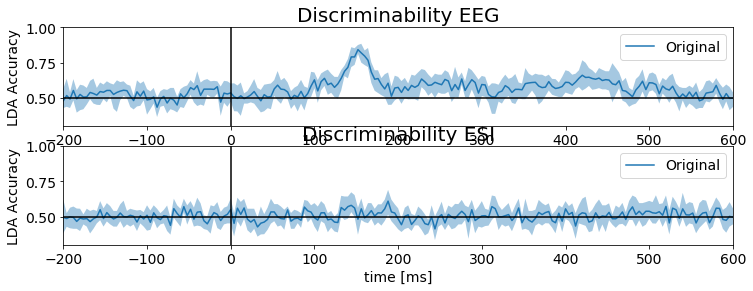

In [52]:
tvec = np.arange(-1500,1000,4)
fig, ax = plt.subplots(2,1,figsize=(12,4))
ax[0].plot(tvec,accuracy_eeg.mean(1),label='Original')
ax[0].fill_between(tvec,np.percentile(accuracy_eeg,5,axis=1),np.percentile(accuracy_eeg,95,axis=1),alpha = 0.4)

ax[0].set_xlim([-200,600])
ax[0].set_ylim([.3,1])
ax[0].axhline(y=0.50, color='k')
ax[0].axvline(x=0.0, color='k')
ax[0].set_title('Discriminability EEG', fontsize=20)
ax[0].set_xlabel('time [ms]',fontsize=14)
ax[0].set_ylabel('LDA Accuracy', fontsize=14)
ax[0].legend(fontsize=14)
ax[0].tick_params(axis="x", labelsize=14)
ax[0].tick_params(axis="y", labelsize=14)

ax[1].plot(tvec,accuracy_esi.mean(1),label='Original')
ax[1].fill_between(tvec,np.percentile(accuracy_esi,5,axis=1),np.percentile(accuracy_esi,95,axis=1),alpha = 0.4)

ax[1].set_xlim([-200,600])
ax[1].set_ylim([.3,1])
ax[1].axhline(y=0.50, color='k')
ax[1].axvline(x=0.0, color='k')
ax[1].set_title('Discriminability ESI', fontsize=20)
ax[1].set_xlabel('time [ms]',fontsize=14)
ax[1].set_ylabel('LDA Accuracy', fontsize=14)
ax[1].legend(fontsize=14)
ax[1].tick_params(axis="x", labelsize=14)
ax[1].tick_params(axis="y", labelsize=14)
